In [1]:
import numpy as np
from functools import reduce

In [2]:
class RowPermutation:
    def __init__(self, from_, to_, band, band_size):
        self.from_ = from_ + band*band_size
        self.to_ = to_ + band*band_size
    
    def __call__(self, matrix):
        r = np.copy(matrix)
        r[[self.to_,self.from_]] = r[[self.from_,self.to_]]
        #print("RowPermutation(", self.from_,",",self.to_,"):", r)
        return r

class BandPermutation:
    def __init__(self, from_, to_, band_size):
        self.from_ = from_
        self.to_ = to_
        self.band_size = band_size
    
    def __call__(self, matrix):
        r = np.copy(matrix)
        r[self.from_*self.band_size:(self.from_+1)*self.band_size] = matrix[self.to_*self.band_size:(self.to_+1)*self.band_size]
        r[self.to_*self.band_size:(self.to_+1)*self.band_size] = matrix[self.from_*self.band_size:(self.from_+1)*self.band_size]
        #print("RowPermutation(", self.from_,",",self.to_,"):", r)
        return r


class TransposePermutation:
    def __init__(self):
        pass

    def __call__(self, matrix):
        #print("TransposePermutation(", "):", matrix.T)
        return matrix.T


class MirrorPermutation:
    def __init__(self, axis):
        self.axis = axis

    def __call__(self, matrix):
        #print("RotateClockwisePermutation(", self.nturns, "):", np.rot90(matrix, k=-self.nturns))
        return np.flip(matrix, axis=self.axis)


class SwapDigitsPermutation:
    def __init__(self, dig1, dig2):
        self.dig1 = dig1 + 1
        self.dig2 = dig2 + 1
    
    def __call__(self, matrix):
        swapper = np.where(matrix==self.dig1, self.dig2, self.dig1)
        r = np.where((matrix==self.dig1) | (matrix==self.dig2), swapper, matrix)
        #print("SwapDigitsPermutation(", self.dig1,",",self.dig2,"):", r)
        return r





In [3]:
compose = lambda F: reduce(lambda f, g: lambda x: g(f(x)), F)

In [4]:
def random_permutation(band_size):
    inds = np.random.choice(np.arange(band_size), size=3, replace=False)
    return np.random.choice([
        RowPermutation(inds[0],inds[1], inds[2], band_size),
        BandPermutation(inds[0],inds[1], band_size),
        TransposePermutation(),
        #MirrorPermutation(np.random.choice(np.array([0,1]))),
        SwapDigitsPermutation(inds[0],inds[1])
    ], p=[0.25,0.25,0.15,0.35]) 

def create_permutations(matrix, count):
    assert matrix.shape[0] == matrix.shape[1], "matrix not square"
    band_size = np.sqrt(matrix.shape[0])
    assert band_size.is_integer(), "Invalid Sudoku size"
    band_size = band_size.astype(int)

    desired_perm_length = 2 + np.emath.logn(matrix.shape[0]*2, count).astype(int)

    permutations = {}
    permutations[tuple(map(tuple, matrix))] = [TransposePermutation(), TransposePermutation()]
    
    while len(permutations) < count:
        rp = [random_permutation(band_size) for i in range(desired_perm_length)]
        pm = tuple(map(tuple, compose(rp)(matrix)))
        permutations[pm] = rp

    return permutations

In [5]:
a = np.arange(81).reshape((9,9))
BandPermutation(0,2,3)(a)

array([[54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26]])

In [6]:
def preprocessing(observation):
    return tf.one_hot(observation, 10, axis=-1)

In [7]:
def majority_vote(pi, obs, nvoters):
    """Perform majority vote

    Keyword arguments:
    pi -- policy
    obs -- observation (a 2d numpy array representing the sudoku)
    nvoters -- number of voters for the majority vote

    """
    votes = {}
    perms = create_permutations(obs, nvoters)
    for perm, perm_function in perms.items():
        obs_ = np.array(perm) #a 2d numpy array representing the sudoku, with elements eg. between 0 and 9
        
        # gather discrete action act from policy
        qs = pi(tf.expand_dims(preprocessing(np.array(perm)), 0))
        act = np.argmax(qs)

        # unravel discrete action and apply to an empty board
        empty_board = np.zeros_like(obs_)
        y,x,n = np.unravel_index(act,(9,9,9))
        empty_board[y,x] = n+1

        # reverse transform on the empty board
        rev = compose(reversed(perm_function))(empty_board)

        # find only non-zero entry in rev, that is the actual action
        nzind_ = next(zip(*np.nonzero(rev)))
        if nzind_ + (rev[nzind_]-1,) not in votes:
            votes[nzind_ + (rev[nzind_]-1,)] = 1
        else:
            votes[nzind_ + (rev[nzind_]-1,)] += 1
    
    # find majority vote
    return max(votes, key=votes.get)

In [8]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os
os.chdir(REPO_PATH)

import tensorflow as tf
import numpy as np
from deepsudoku.reinforcement_learning.ppo import *

import gymnasium as gym
from deepsudoku.verify_sudoku import *

2023-09-03 15:10:03.325190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-03 15:10:03.354559: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-03 15:10:03.355375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 15:10:03.919484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


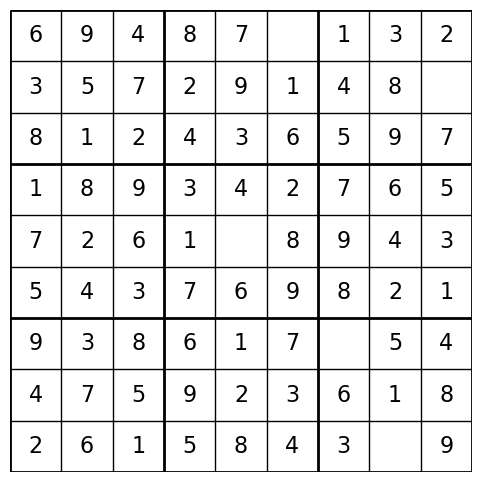

In [19]:
pi = tf.keras.models.load_model('notebooks/ppo_tests/some_model')
test_env = gym.make('Sudoku-x0', render_mode='human', size=3, missing_digits=5)
obs, inf = test_env.reset()
test_env.render()

In [20]:
majority_vote(pi, obs, 1000)

(1, 8, 8)